In [172]:
import pandas as pd
import numpy as np

from geopy.distance import geodesic
from collections import deque

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# режимы движения на отрезках маршрута
traffic_mode = pd.DataFrame(
    {
        'ice_class': ['No ice class', 'Ice1', 'Ice2', 'Ice3', 'Arc4', 'Arc5', 'Arc6', 'Arc7', 'Arc8', 'Arc9'],
        **{num: ['self', 'self', 'self', 'self', 'self', 'self', 'self', 'self', 'self', 'self'] for num in range(4)},
        **{num: ['wiring', 'wiring', 'wiring', 'wiring', 'self', 'self', 'self', 'self', 'self', 'self'] for num in range(4, 7)},
        **{num: ['forbidden', 'forbidden', 'forbidden', 'forbidden', 'wiring', 'wiring', 'wiring', 'self', 'self', 'self'] 
           for num in range(7, 10)},
    }
)

traffic_mode

,ice_class,0,1,2,3,4,5,6,7,8,9
0,No ice class,self,self,self,self,wiring,wiring,wiring,forbidden,forbidden,forbidden
1,Ice1,self,self,self,self,wiring,wiring,wiring,forbidden,forbidden,forbidden
2,Ice2,self,self,self,self,wiring,wiring,wiring,forbidden,forbidden,forbidden
3,Ice3,self,self,self,self,wiring,wiring,wiring,forbidden,forbidden,forbidden
4,Arc4,self,self,self,self,self,self,self,wiring,wiring,wiring
5,Arc5,self,self,self,self,self,self,self,wiring,wiring,wiring
6,Arc6,self,self,self,self,self,self,self,wiring,wiring,wiring
7,Arc7,self,self,self,self,self,self,self,self,self,self
8,Arc8,self,self,self,self,self,self,self,self,self,self
9,Arc9,self,self,self,self,self,self,self,self,self,self


In [3]:
# информация по ледоклам
icebreakers = pd.read_csv('icebreakers.csv', encoding='utf-8', sep=';')
icebreakers.columns = ['name', 'imo']
icebreakers

,name,imo
0,50 лет Победы,9152959
1,Ямал,9077549
2,Таймыр,8417481
3,Вайгач,8417493


In [4]:
# сплоченность льдов
cohesion = pd.read_csv('cohesion.csv', encoding='utf-8', sep=';')
cohesion = cohesion.rename(columns={
    'Номер ребра': 'edge_num',
})
cohesion.head()

,edge_num,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2
1,2,0,1,1,1,1,2,2,2,2,...,4,4,4,4,4,4,4,5,5,5
2,3,1,1,1,1,2,2,2,2,2,...,4,4,5,5,5,5,6,6,6,6
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,2,2


In [95]:
# путь от самой заподной вершины
PATH_1 = [1, 2, 3, 7, 8, 9, 10]
PATH_2 = [4, 5, 6, 7, 8, 9, 10]

# до трех возможных портов
PORTS = [[12, 14], [12, 13], [11]]

TO = {
    'Саббета 1': [PATH_1 + PORTS[0], PATH_2 + PORTS[0]],
    'Саббета 2': [PATH_1 + PORTS[1], PATH_2 + PORTS[1]],
    'Саббета 3': [PATH_1 + PORTS[2], PATH_2 + PORTS[2]],
}

In [7]:
requests = pd.read_csv('requests.csv', encoding='utf-8', sep=';')

requests['Дата и время начала плавания'] = pd.to_datetime(requests['Дата и время начала плавания'], format='%d.%m.%Y %H:%M')
requests['Дата и время окончания плавания'] = pd.to_datetime(requests['Дата и время окончания плавания'], format='%d.%m.%Y %H:%M')

requests.columns = [
    'name', 'imo', 'ice_class', 'speed', 'start_point', 'end_point', 'date_start', 'date_end'
]

requests.start_point = requests.start_point.str.strip()

for val in range(1, 3):
    requests.start_point = requests.start_point.str.replace(f'Сабетта {val}', f'Саббета {val}')
    requests.end_point = requests.end_point.str.replace(f'Сабетта {val}', f'Саббета {val}')

requests.speed *= 1.852  # переводим уздлы в км/ч 

requests.head()

,name,imo,ice_class,speed,start_point,end_point,date_start,date_end
0,Штурман Альбанов,9752084,Arc7,27.78,точка в Баренцевом море,Саббета 3,2021-01-01 23:30:00,2021-01-05 05:00:00
1,Штурман Альбанов,9752084,Arc7,27.78,Саббета 3,точка в Баренцевом море,2021-01-06 11:00:00,2021-01-10 18:00:00
2,Штурман Альбанов,9752084,Arc7,27.78,точка в Баренцевом море,Саббета 3,2021-01-12 18:00:00,2021-01-16 22:00:00
3,Штурман Альбанов,9752084,Arc7,27.78,Саббета 3,точка в Баренцевом море,2021-01-17 06:00:00,2021-01-21 20:45:00
4,Штурман Альбанов,9752084,Arc7,27.78,точка в Баренцевом море,Саббета 3,2021-01-21 09:00:00,2021-01-26 22:00:00


In [8]:
# функция для учета дней в декабре и феврале 
def clip_day(date):
    if date.month == 12:
        return 1
    if date.month == 2 or date.day == 31:
        return 30
    return date.day

# функция для определения необходимости проводки
def is_wiring_needed(ice_class, speed, start_point, end_point, date_start, date_end): 
    if 'Саббета' in start_point:
        routes = [route[::-1] for route in TO[start_point]]
    else:
        routes = TO[end_point]
    
    start_day = clip_day(date_start)
    end_day = clip_day(date_end)
    
    for route in routes:
        max_difficulty = cohesion[cohesion.edge_num.isin(route)].loc[:, str(start_day):str(end_day)].values.max()
        mode = traffic_mode[traffic_mode.ice_class == ice_class][max_difficulty].values[0]
        decreased_speed = speed * (1 - max_difficulty * 0.07)
        
        if decreased_speed < 9 * 1.852:
            return True
        if mode != 'self':
            return True
    return False         

In [9]:
requests['wiring_needed'] = requests.apply(lambda x: is_wiring_needed(x['ice_class'], x['speed'], x['start_point'], x['end_point'], x['date_start'], x['date_end']), axis=1)

In [10]:
requests['start_point'].unique()

array(['точка в Баренцевом море', 'Саббета 3', 'Саббета 2', 'Саббета 1'],
      dtype=object)

In [11]:
print('Уникальных судов: ', requests.imo.nunique())

Уникальных судов:  17


In [12]:
print('Уникальные классы судов')
requests.pivot_table(index='ice_class', values='imo', aggfunc='nunique')

Уникальные классы судов


,imo
ice_class,
Arc4,4
Arc5,3
Arc7,8
No ice class,2


In [13]:
POINT_IN_SEA = (69.930300, 46.142578)
SABBETA_1 = (68.664551, 73.528748)
SABBETA_2 = (71.033035, 73.712769)
SABBETA_3 = (71.244356, 72.202148)

def set_point_coordinates(name):
    if name == 'точка в Баренцевом море':
        return POINT_IN_SEA
    if name == 'Саббета 3':
        return SABBETA_3
    if name == 'Саббета 2':
        return SABBETA_2
    if name == 'Саббета 1':
        return SABBETA_1
    
requests['start_point_coord'] = requests['start_point'].apply(set_point_coordinates)
requests['end_point_coord'] = requests['end_point'].apply(set_point_coordinates)

In [175]:
requests.tail()

,name,imo,ice_class,speed,start_point,end_point,date_start,date_end,wiring_needed,start_point_coord,end_point_coord
42,LNG DUBHE,9834296,No ice class,29.632,Саббета 1,точка в Баренцевом море,2021-01-06 15:00:00,2021-01-08 16:00:00,True,"(68.664551, 73.528748)","(69.9303, 46.142578)"
43,LNG DUBHE,9834296,No ice class,29.632,точка в Баренцевом море,Саббета 1,2021-01-12 10:00:00,2021-01-14 16:30:00,True,"(69.9303, 46.142578)","(68.664551, 73.528748)"
44,LNG DUBHE,9834296,No ice class,29.632,Саббета 1,точка в Баренцевом море,2021-01-13 19:30:00,2021-01-15 10:00:00,True,"(68.664551, 73.528748)","(69.9303, 46.142578)"
45,LNG DUBHE,9834296,No ice class,29.632,точка в Баренцевом море,Саббета 1,2021-01-22 07:00:00,2021-01-24 18:30:00,True,"(69.9303, 46.142578)","(68.664551, 73.528748)"
46,LNG DUBHE,9834296,No ice class,29.632,Саббета 1,точка в Баренцевом море,2021-01-23 00:30:00,2021-01-25 23:30:00,True,"(68.664551, 73.528748)","(69.9303, 46.142578)"


In [15]:
graph_availability = pd.read_csv('graph_availability.csv', encoding='utf-8', sep=';')
graph_availability = graph_availability.rename(columns={
    'Номер ребра': 'edge_num',
})
graph_availability

,edge_num,50 лет Победы,Ямал,Таймыр,Вайгач
0,1,1,1,1,1
1,2,1,1,1,1
2,3,1,1,1,1
3,4,1,1,1,1
4,5,1,1,1,1
5,6,1,1,1,1
6,7,1,1,1,1
7,8,1,1,1,1
8,9,1,1,1,1
9,10,1,1,1,1


In [16]:
coordinates = pd.read_csv('json_coords.csv', encoding='utf-8', sep=',')
coordinates = coordinates.drop(['type', 'geometry_type'], axis=1)
coordinates = coordinates.rename(columns={
    'properties_id': 'edge_num',
    'geometry_coordinates_0_1': 'lat_0',
    'geometry_coordinates_0_0': 'lon_0',
    'geometry_coordinates_1_1': 'lat_1', 
    'geometry_coordinates_1_0': 'lon_1'})

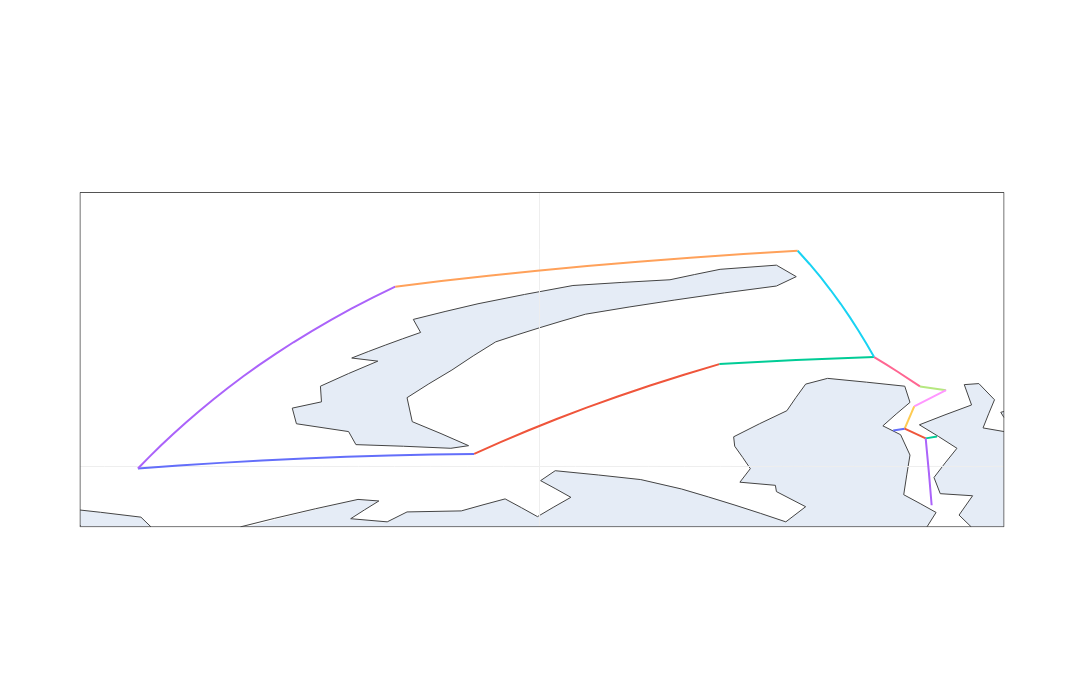

In [17]:
MARGIN = 2

fig = go.Figure()

i = 0
while i < coordinates.shape[0]:

    fig.add_trace(go.Scattergeo(
        lon=[coordinates.loc[i, 'lon_0'], coordinates.loc[i, 'lon_1']],
        lat=[coordinates.loc[i, 'lat_0'], coordinates.loc[i, 'lat_1']],
        mode='lines',
        hoverinfo='text',
        text=str(coordinates.loc[i, 'edge_num']),
    ))
    
    i += 1
    
fig.update_layout(
    width = 800,
    height = 700,
    showlegend = False,
    geo = dict(
        lataxis = dict(
            range = [coordinates.lat_0.min()-MARGIN, coordinates.lat_1.max()+MARGIN],
            showgrid = True,
            dtick = 10
        ),
        lonaxis = dict(
            range = [coordinates.lon_0.min()-MARGIN, coordinates.lon_1.max()+MARGIN],
            showgrid = True,
            dtick = 20
        ),
    ),
)
    
fig.show()

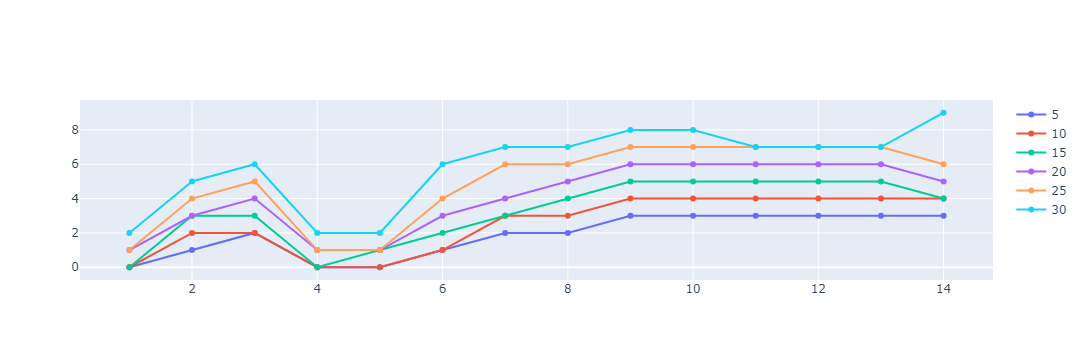

In [252]:
# нарисуем как меняется сплоченность льда в январе по дням
fig = go.Figure()

for i in range(5, 31, 5):
    fig.add_trace(go.Scatter(
        x=cohesion['edge_num'], y=cohesion[str(i)], name=str(i)
    ))
    
fig.show()

In [18]:
def get_distance(lat_0, lon_0, lat_1, lon_1):
    return geodesic((lat_0, lon_0), (lat_1, lon_1)).km

coordinates['distance'] = coordinates.apply(lambda x: get_distance(x['lat_0'], x['lon_0'], x['lat_1'], x['lon_1']), axis=1)

In [105]:
coordinates

,edge_num,lon_0,lat_0,lon_1,lat_1,distance
0,1,46.142578,69.930300,57.744141,70.436799,442.053045
1,2,57.744141,70.436799,66.203613,73.534628,451.740435
2,3,66.203613,73.534628,71.542969,73.775780,169.870241
3,4,46.142578,69.930300,55.019531,76.205967,755.572096
4,5,55.019531,76.205967,68.906250,77.446940,378.488196
5,6,68.906250,77.446940,71.542969,73.775780,416.166793
6,7,71.542969,73.775780,73.125000,72.764065,123.821180
7,8,73.125000,72.764065,74.025879,72.633374,33.281169
8,9,74.025879,72.633374,72.927246,72.073911,72.664156
9,10,72.927246,72.073911,72.597656,71.307836,86.258602


In [142]:
requests_self = requests[requests.wiring_needed == False]
requests_wiring = requests[requests.wiring_needed == True]

In [244]:
def find_routes_with_wiring(ice_class, speed, start_point, end_point, date_start, date_end):
    if 'Саббета' in start_point:
        routes = [route[::-1] for route in TO[start_point]]
    else:
        routes = TO[end_point]

    start_day = date_start.day
    end_day = date_end.day
    
    # определяем число минут в каждом дне
    if date_start.date() == date_end.date():
        hours_per_day = [(date_end - date_start).total_seconds() / 60 / 24]
    else:
        full_days = (date_end - date_start).days - 1
        hours_per_day = [24 - date_start.hour - date_start.minute / 60] + [24 for _ in range(full_days)] + \
                          [date_end.hour + date_end.minute / 60]

    route_time = []
    route_distance = []
    max_edge = []
    needed_wiring = []

    for route in routes:
        r = route.copy()
        flag = True
        
        needed_wiring.append([])
        
        while flag:
            total_time = 0
            
            edges = deque(r)
            hours = deque(hours_per_day)
            i = 0
            
            if not edges:
                max_edge.append('not allowed')
                break
            
            edge = edges.popleft()
            hour = hours.popleft()
            dist = coordinates.loc[coordinates.edge_num == edge, 'distance'].values[0]

            while True:

                day = clip_day(date_start + pd.DateOffset(days=i))

                difficulty = cohesion[cohesion['edge_num'] == edge][str(day)].values[0]
                mode = traffic_mode[traffic_mode.ice_class == ice_class][difficulty].values[0] 
                decreased_speed = speed * (1 - difficulty * 0.07)
                
                if mode == 'forbidden':
                    flag = False
                    max_edge.append('not allowed')
                    break
                elif mode == 'wiring' or decreased_speed < 9 * 1.852:
                    decreased_speed = 9 * 1.852
                    if edge not in needed_wiring[-1]:
                        needed_wiring[-1].append(edge)
                    
                hours_needed = dist / decreased_speed

                if hours_needed <= hour:
                    total_time += hours_needed
                    hour -= hours_needed

                    if not edges:
                        flag = False
                        break

                    edge = edges.popleft()
                    
                    dist = coordinates.loc[coordinates.edge_num == edge, 'distance'].values[0]
                else:
                    total_time += hour

                    if not hours:
                        r.remove(min(r))  # удаляем одно ребро в Баренцевом море
                        break

                    i += 1  # следующий день
                    
                    dist -= hour * decreased_speed
                    hour = hours.popleft()
        
        if r and 'not allowed' not in max_edge:
            max_edge.append(min(r))
            route_distance.append(coordinates.loc[coordinates.edge_num.isin(r), 'distance'].values.sum())
        route_time.append(total_time)
        
    
    return {
        'edges_of_routes': max_edge,
        'opt_time_of_routes': route_time,
        'distance_of_routes': route_distance,
        'needed_wiring': needed_wiring
    }
    

In [245]:
res = requests.apply(lambda x: find_routes_with_wiring(x['ice_class'], x['speed'], x['start_point'], x['end_point'], x['date_start'], x['date_end']), axis=1)

In [250]:
res[30]

{'edges_of_routes': [1, 4],
 'opt_time_of_routes': [75.2539759921851, 91.96745741188643],
 'distance_of_routes': [1441.0871627359327, 1927.6505271784379],
 'needed_wiring': [[7, 8, 9, 10, 12, 13], [7, 8, 9, 10, 12, 13]]}

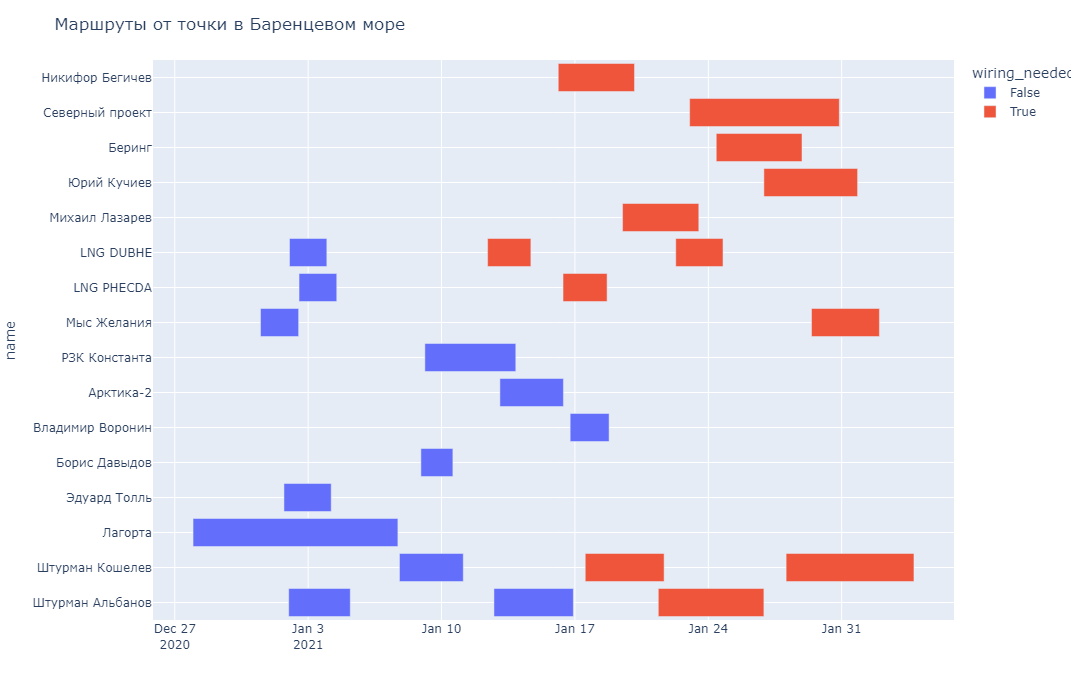

In [185]:
fig = px.timeline(requests[requests.start_point == 'точка в Баренцевом море'], 
                  x_start='date_start', x_end='date_end', y='name', color='wiring_needed')
fig.update_layout(height=700, yaxis=dict(showgrid=True), title='Маршруты от точки в Баренцевом море')
fig.show()

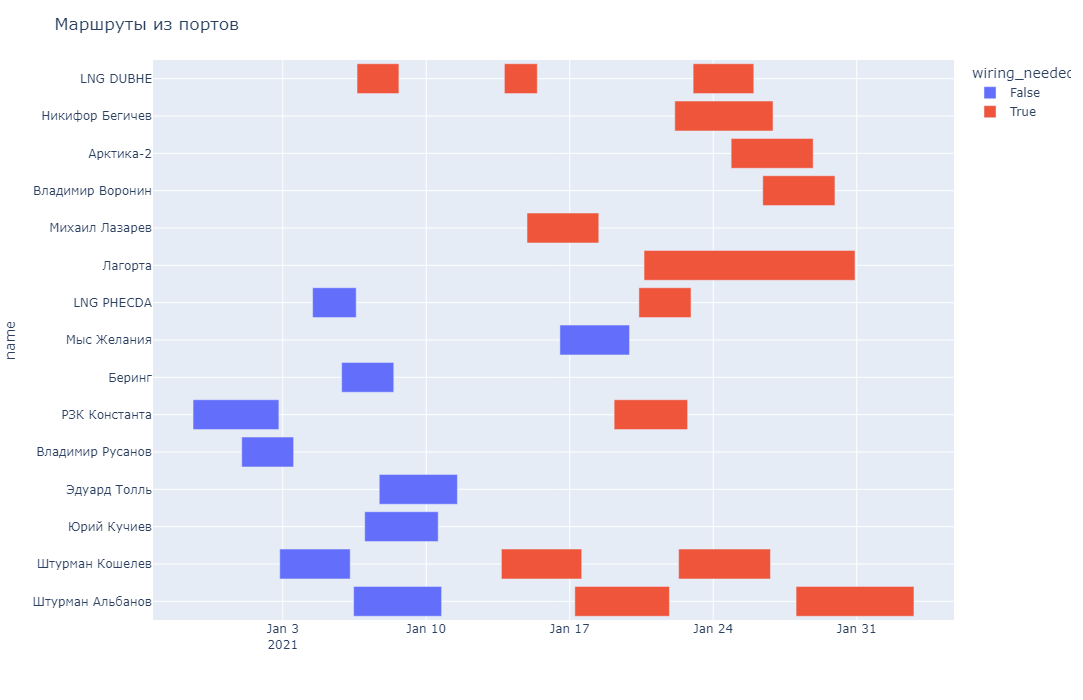

In [186]:
fig = px.timeline(requests[requests.start_point != 'точка в Баренцевом море'], 
                  x_start='date_start', x_end='date_end', y='name', color='wiring_needed')
fig.update_layout(height=700, yaxis=dict(showgrid=True), title='Маршруты из портов')
fig.show()

In [251]:
requests.head()

,name,imo,ice_class,speed,start_point,end_point,date_start,date_end,wiring_needed,start_point_coord,end_point_coord
0,Штурман Альбанов,9752084,Arc7,27.78,точка в Баренцевом море,Саббета 3,2021-01-01 23:30:00,2021-01-05 05:00:00,False,"(69.9303, 46.142578)","(71.244356, 72.202148)"
1,Штурман Альбанов,9752084,Arc7,27.78,Саббета 3,точка в Баренцевом море,2021-01-06 11:00:00,2021-01-10 18:00:00,False,"(71.244356, 72.202148)","(69.9303, 46.142578)"
2,Штурман Альбанов,9752084,Arc7,27.78,точка в Баренцевом море,Саббета 3,2021-01-12 18:00:00,2021-01-16 22:00:00,False,"(69.9303, 46.142578)","(71.244356, 72.202148)"
3,Штурман Альбанов,9752084,Arc7,27.78,Саббета 3,точка в Баренцевом море,2021-01-17 06:00:00,2021-01-21 20:45:00,True,"(71.244356, 72.202148)","(69.9303, 46.142578)"
4,Штурман Альбанов,9752084,Arc7,27.78,точка в Баренцевом море,Саббета 3,2021-01-21 09:00:00,2021-01-26 22:00:00,True,"(69.9303, 46.142578)","(71.244356, 72.202148)"
